In [1]:
pip install rouge

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from rouge import Rouge

# Load dataset
data = pd.read_csv("Reviews.csv",nrows=5000)
# Drop Duplicates and NA values
data.drop_duplicates(subset=['Text'], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na
data = data.reset_index(drop=True)


# Preprocessing
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return " ".join(tokens)

data['Text'] = data['Text'].apply(preprocess_text)

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data['Text'])
vocab_size = len(tokenizer.word_index) + 1

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(data['Text'], data['Summary'], test_size=0.2, random_state=42)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

empty_summaries = y_train[y_train == '']
if len(empty_summaries) > 0:
    print("Found {} empty summaries in y_train.".format(len(empty_summaries)))
    # Handle empty summaries as needed (e.g., remove them from the dataset)
# Handle empty summaries in y_train (e.g., remove them)
y_train = y_train[y_train != '']

# Pad sequences
max_length = 100  # Assuming maximum sequence length
# Pad sequences with zeros and apply masking
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

# Masking for padded tokens
mask = (X_train_padded != 0).astype(float)

# Actor-Critic model
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions, vocab_size):
        super(ActorCritic, self).__init__()
        # Actor network
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_actions, activation='softmax')
        ])
        # Critic network
        self.critic = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, state):
        # Forward pass for actor network
        action_probs = self.actor(state)
        # Forward pass for critic network
        value = self.critic(state)
        return action_probs, value

# Custom loss functions
def actor_loss(action_probs, advantages):
    return -tf.reduce_mean(tf.math.log(action_probs) * advantages)

def critic_loss(value, returns):
    return tf.reduce_mean(tf.square(returns - value))

# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Training function
def train_step(actor_critic, states, actions, returns, advantages):
    with tf.GradientTape() as tape:
        # Forward pass
        action_probs, values = actor_critic(states)
        # Calculate actor and critic losses
        actor_loss_val = actor_loss(action_probs, advantages)
        critic_loss_val = critic_loss(values, returns)
        total_loss = actor_loss_val + critic_loss_val
    # Compute gradients
    grads = tape.gradient(total_loss, actor_critic.trainable_variables)
    # Apply gradients
    optimizer.apply_gradients(zip(grads, actor_critic.trainable_variables))
    return total_loss

# Example usage
num_actions = 10  # Number of actions (e.g., size of vocabulary for text summarization)
actor_critic = ActorCritic(num_actions, vocab_size)

# Define ROUGE score calculation function
def calculate_rouge(generated_summary, ground_truth_summary):
    if not ground_truth_summary.strip():  # Check if the ground truth summary is empty
        return 0.0  # Return a default value or handle it as appropriate
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, ground_truth_summary)
    return scores[0]['rouge-1']['f']




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
def generate_summary(actor_critic, text):
    state = tokenizer.texts_to_sequences([text])
    state = tf.keras.preprocessing.sequence.pad_sequences(state, maxlen=max_length, padding='post')
    action_probs, _ = actor_critic(state)
    action_probs = action_probs[0]  # Extract probabilities from batch
    print("Action probabilities before softmax:", action_probs)  # Print action_probs for debugging
    # Use softmax with epsilon for numerical stability
    epsilon = 1e-8  # Small epsilon value
    action_probs = tf.nn.softmax(action_probs + epsilon).numpy()
    print("Action probabilities after softmax:", action_probs)  # Print action_probs after softmax for debugging
    # Choose action index based on probabilities
    action = np.random.choice(len(action_probs), p=action_probs)
    summary = tokenizer.index_word.get(action, 'UNK')  # Get word corresponding to action index
    return summary


Streaming output truncated to the last 5000 lines.
Normalized reward: 0.0
Returns: [0.]
Advantages: tf.Tensor([[-5.928392e-06]], shape=(1, 1), dtype=float32)
Loss: tf.Tensor(-1.3650592e-05, shape=(), dtype=float32)
INPUT TEXT:
great usb audio interface also shure perform wish would known spent way
-----------
Input sequence: [[   8  814 1179 1756   24 1958 3462  265   13 1032 1499   65    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Value estimates: tf.Tensor([[-2.9442384e-05]], shape=(1, 1), dtype=float32)
Action probabilities before softmax: tf.Tensor(
[0.10001964 0.09996863 0.100007

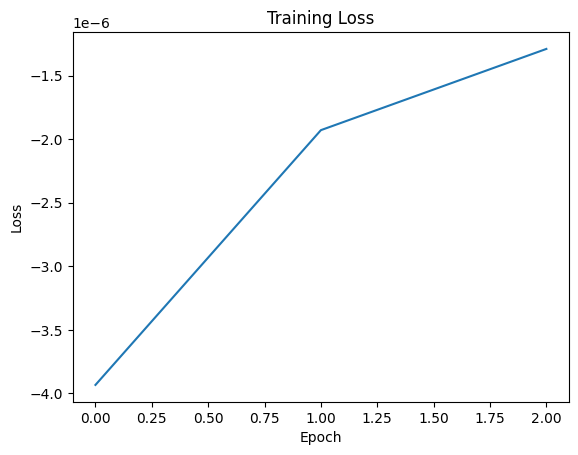

In [11]:
# Training loop with reward normalization, reward clipping, and compute returns
import matplotlib.pyplot as plt

# Initialize variables
losses = []
epoch_losses = []
# Reward clipping function
def clip_reward(reward):
    return max(min(reward, 1.0), -1.0)

# Compute returns function
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return np.array(returns)

# Training loop
NUM_EPOCHS = 3
gamma = 0.99  # Discount factor
for epoch in range(NUM_EPOCHS):
    for text, summary in zip(X_train, y_train):
        # Preprocess input text
        print("INPUT TEXT:")
        print(text)
        print("-----------")
        state = tokenizer.texts_to_sequences([text])
        state = tf.keras.preprocessing.sequence.pad_sequences(state, maxlen=max_length, padding='post')
        if np.isnan(state).any():
            print("NaN values found in input sequence:", state)
            continue
        print("Input sequence:", state)  # Debug print
        # Forward pass through critic network to get value estimates
        _, value = actor_critic(state)
        if np.isnan(value).any():
            print("NaN values found in value estimates:", value)
            continue
        print("Value estimates:", value)  # Debug print
        # Generate summary using the actor network
        generated_summary = generate_summary(actor_critic, text)
        print("Generated summary:", generated_summary)  # Debug print
        # Calculate reward (ROUGE score)
        reward = calculate_rouge(str(generated_summary), str(summary))
        print("Raw reward (ROUGE score):", reward)  # Debug print
        # Reward clipping
        reward = clip_reward(reward)
        print("Clipped reward:", reward)  # Debug print
        # Normalize reward
        reward = (reward - np.mean(reward)) / (np.std(reward) + 1e-8)
        print("Normalized reward:", reward)  # Debug print
        # Compute returns and advantages
        returns = compute_returns([reward], gamma)
        print("Returns:", returns)  # Debug print
        advantages = returns - value
        print("Advantages:", advantages)  # Debug print
        # Perform training step
        loss = train_step(actor_critic, state, summary, returns, advantages)
        print("Loss:", loss)  # Debug print
        epoch_losses.append(loss)
    epoch_loss_avg = np.mean(epoch_losses)
    losses.append(epoch_loss_avg)

# Plot the loss graph
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
